In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Conv1D,GlobalMaxPooling1D,Input,Lambda,Conv2D,Dropout
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from keras import backend as K
plt.style.use('ggplot')
%matplotlib inline
import tensorflow_hub as hub


Using TensorFlow backend.


### Data Prep

In [2]:
filepath_dict = {'yelp': "datasets/sentiment_labelled_sentences/yelp_labelled.txt",
                 'amazon': "datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt",
                 'imdb': "datasets/sentiment_labelled_sentences/imdb_labelled.txt"
                 }
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
   # Add another column filled with the source name
    df['source'] = source
    df_list.append(df)  
    df = pd.concat(df_list)

In [3]:
df = df[df['source']== "yelp"]
sentences = df['sentence'].values
y = df['label'].values

sentences_token = [text_to_word_sequence(sentence.strip().lower()) for sentence in sentences]
sentences_len = [len(s) for s in sentences]
maxlen = max(sentences_len)

sentences_train,sentences_test,y_train,y_test = train_test_split(
                                                sentences, y,
                                                test_size=0.15,
                                                random_state=1000)


tokenizer = Tokenizer(lower=True) #num_words=10000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# maxlen = 100
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# y_train = to_categorical(num_classes=2,y=y_train)
# y_test = to_categorical(num_classes=2,y=y_test)

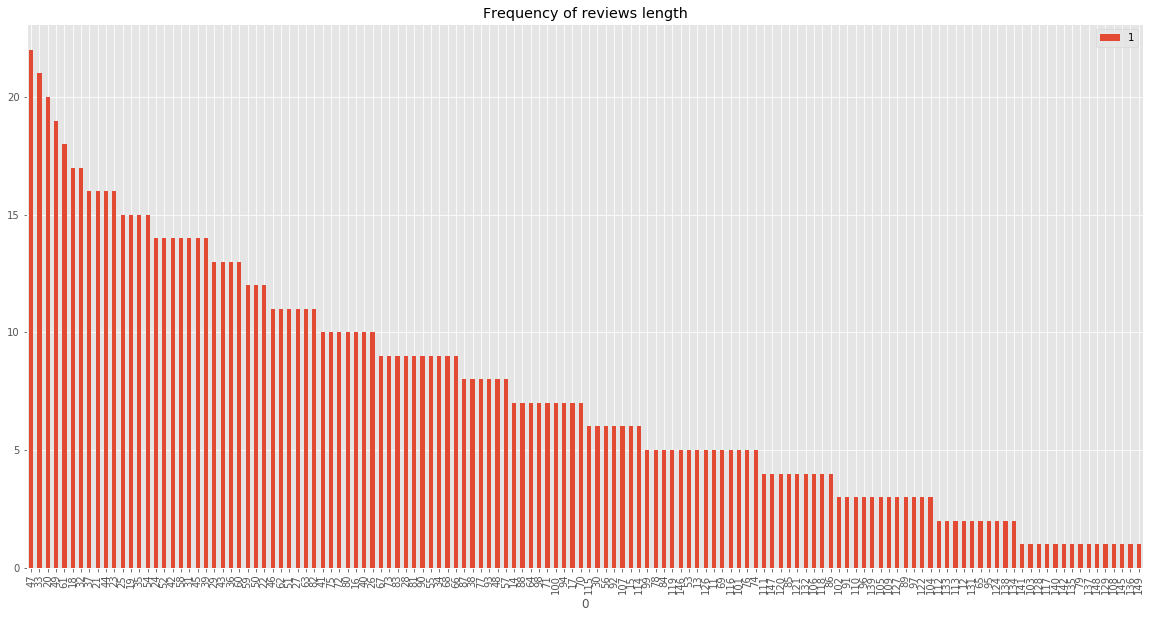

In [4]:
from collections import Counter
import pandas as pd

pd.DataFrame(Counter(sentences_len).most_common()).plot(kind="bar",x=0,y=1,figsize=(20,10),
                                                        title="Frequency of reviews length")

In [5]:

#computing different metrics for measuring performance
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# module_url = "https://tfhub.dev/google/elmo/3"
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

#plotting the train and test data points in order to track the training

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.legend()

## ELMo Embeddings

In [6]:
import tensorflow_hub as hub


tf.compat.v1.disable_eager_execution()
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
embeddings = elmo(sentences_train,
    signature="default",
    as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## LSTM Model

In [7]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]
def createLSTM():
    hub_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", output_shape=[],
                           input_shape=[None,], dtype=tf.string)
    model = tf.keras.Sequential()
    model.add(Input(shape=(1,), dtype="string"))
    model.add(Lambda(ELMoEmbedding, output_shape=(1024, ),name="elmo_embedding_layer"))
    model.add(LSTM(192,))
    model.add(Dropout(0.5))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


def create_base_LSTM():
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=128, 
                        input_length=maxlen))
    model.add(LSTM(192,))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 149, 128)          239872    
_________________________________________________________________
lstm (LSTM)                  (None, 192)               246528    
_________________________________________________________________
dense (Dense)                (None, 100)               19300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 505,801
Trainable params: 505,801
Non-trainable params: 0
_________________________________________________________________
Train on 850 samples, validate on 150 samples
Epoch 1/5
850/850 [==============================] - 4s 5ms/sample - loss: 0.6943 - accuracy: 0.4871 - val_loss: 0.6936 - val_accuracy: 0.4800
Epoch 2/5
850/850 [==============================] - 4s 5ms

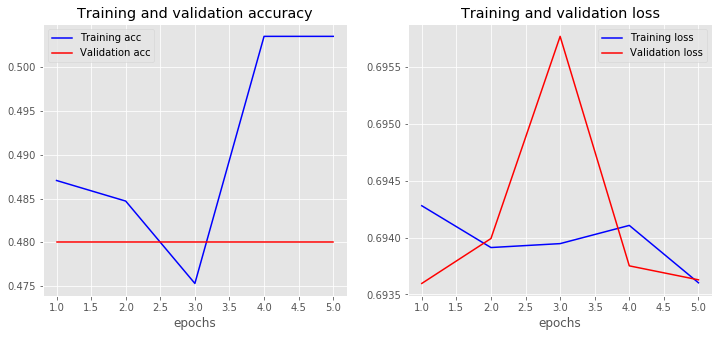

In [8]:
bmodel= create_base_LSTM()
bmodel.summary()
bmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
plot_model(bmodel, to_file='sentiment_basic_embedding_lstm.png',show_shapes=True, show_layer_names=True)
# history = model.fit(sentences_train,y_train,batch_size=16,epochs=3,verbose=1)
# validation_data=(sentences_test, y_test)
history = bmodel.fit(X_train,y_train,batch_size=32,epochs=5,verbose=1,validation_data=(X_test, y_test))
plot_history(history)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elmo_embedding_layer (Lambda (None, None, 1024)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 192)               934656    
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6176      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 940,865
Trainable params: 940,865
Non-trainable params: 0
_________________________________________________________________
Train on 850 samples, validate on 150 samples
Epoch 1/5
850/850 [==============================] - 49s 58ms/sample

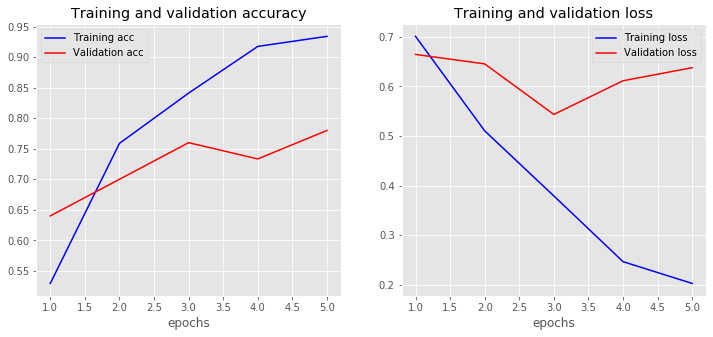

In [9]:
with tf.compat.v1.Session() as session:
    tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    model= createLSTM()
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    plot_model(model, to_file='sentiment_elmo_embedding_lstm.png',show_shapes=True, show_layer_names=True)
    history = model.fit(sentences_train,y_train,batch_size=32,epochs=5,verbose=1,validation_data=(sentences_test, y_test))
    # validation_data=(sentences_test, y_test)
    # history = model.fit(embeddings_train,y_train,batch_size=16,epochs=10,verbose=1)
    plot_history(history)
    model.evaluate(sentences_test,y_test)




# CNN

In [20]:



def createCNN(vocab_size,embedding_dim,maxlen):
    model = Sequential()
    model.add(Input(shape=(1,), dtype="string"))
    model.add(Lambda(ELMoEmbedding, output_shape=(1024, ),name="elmo_embedding_layer"))
    model.add(Conv1D(32, 3, activation='relu')) #padding= "Same"
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elmo_embedding_layer (Lambda (None, None, 1024)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          98336     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 98,677
Trainable params: 98,677
Non-trainable params: 0
_________________________________________________

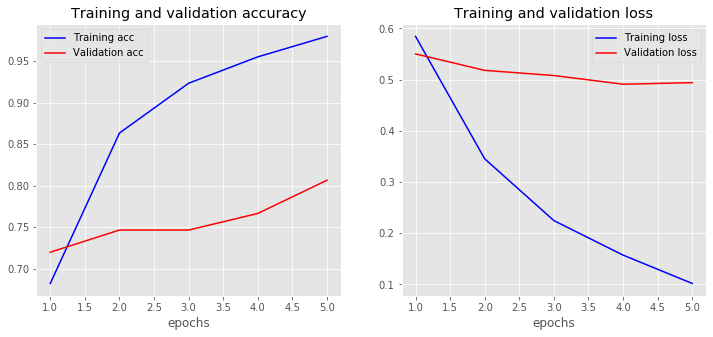

In [26]:

with tf.compat.v1.Session() as session:
    tf.compat.v1.keras.backend.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    cnn_model=createCNN(vocab_size,100,maxlen)
    
    cnn_model.summary()
    plot_model(cnn_model, to_file='sentiment_elmo_embedding_cnn.png',show_shapes=True, show_layer_names=True)
    cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    history = cnn_model.fit(sentences_train,y_train,batch_size=32,epochs=5,validation_data=(sentences_test, y_test),verbose=1)
    plot_history(history)
